In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import CuDNNLSTM

from tangle import read_activations
from tangle.mbspbs10pc import utils

reload(read_activations)
reload(utils);

root = 'dl'

Using TensorFlow backend.


# Load raw data

In [2]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timespan_seq, _ = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timespan_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False)

In [3]:
tr_set[0][0].shape

(6341, 250)

# Init embedding matrix

In [4]:
D = 50
embedding = pd.read_csv('../../tmp/embedding.{}d.csv'.format(D), header=0, index_col=0)
embedding_matrix = embedding.values
embedding_matrix.shape

(2774, 50)

# Model

In [21]:
from tangle import model as mbs_model
reload(mbs_model);

model = mbs_model.build_tangle(mbs_input_shape=(maxlen,),
                               timespan_input_shape=(maxlen, 1),
                               vocabulary_size=2774,
                               embedding_size=50,
                               recurrent_units=32,
                               dense_units=32,
                               attention_units=128,
                               bidirectional=True,
                               LSTMLayer=CuDNNLSTM)

# model = mbs_model.build_attention_model(mbs_input_shape=(maxlen,),
#                                         timespan_input_shape=(maxlen, 1),
#                                         vocabulary_size=2774,
#                                         embedding_size=50,
#                                         recurrent_units=32,
#                                         dense_units=32,
#                                         attention_units=128,
#                                         bidirectional=True,
#                                         LSTMLayer=CuDNNLSTM)

# model = mbs_model.build_baseline_model(mbs_input_shape=(maxlen,),
#                                        timespan_input_shape=(maxlen, 1),
#                                        vocabulary_size=2774,
#                                        embedding_size=50,
#                                        recurrent_units=32,
#                                        dense_units=32,
#                                        bidirectional=True,
#                                        LSTMLayer=CuDNNLSTM)

In [22]:
from keras import optimizers as opt
model.compile(optimizer=opt.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['acc'])

In [23]:
model.get_layer('mbs_embedding').set_weights([embedding_matrix])
model.get_layer('mbs_embedding').trainable = True

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mbs_input (InputLayer)          (None, 250)          0                                            
__________________________________________________________________________________________________
mbs_embedding (Embedding)       (None, 250, 50)      138700      mbs_input[0][0]                  
__________________________________________________________________________________________________
timespan_input (InputLayer)     (None, 250, 1)       0                                            
__________________________________________________________________________________________________
mbs_lstm (Bidirectional)        (None, 250, 64)      21504       mbs_embedding[0][0]              
__________________________________________________________________________________________________
timespan_l

In [28]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [29]:
# from keras.utils import plot_model

# plot_model(model, show_shapes=True, to_file='tangle.png')

In [32]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1),
             EarlyStopping(monitor='val_loss', patience=5)] 

history = model.fit(tr_set[0], tr_set[1],
                    epochs=10,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(v_set))

Train on 6341 samples, validate on 705 samples
Epoch 1/10
6341/6341 [==============================] - 3s 494us/step - loss: 0.2152 - acc: 0.9385 - val_loss: 0.8058 - val_acc: 0.7702
Epoch 2/10
6341/6341 [==============================] - 3s 476us/step - loss: 0.2075 - acc: 0.9457 - val_loss: 0.7364 - val_acc: 0.7759
Epoch 3/10
6341/6341 [==============================] - 3s 471us/step - loss: 0.1929 - acc: 0.9486 - val_loss: 0.8999 - val_acc: 0.7674
Epoch 4/10
6341/6341 [==============================] - 3s 475us/step - loss: 0.1696 - acc: 0.9598 - val_loss: 0.8704 - val_acc: 0.7759
Epoch 5/10
6341/6341 [==============================] - 3s 456us/step - loss: 0.1547 - acc: 0.9655 - val_loss: 1.1363 - val_acc: 0.7660
Epoch 6/10
6341/6341 [==============================] - 3s 478us/step - loss: 0.1507 - acc: 0.9704 - val_loss: 1.0488 - val_acc: 0.7631
Epoch 7/10
6341/6341 [==============================] - 3s 502us/step - loss: 0.1388 - acc: 0.9741 - val_loss: 1.0280 - val_acc: 0.7617


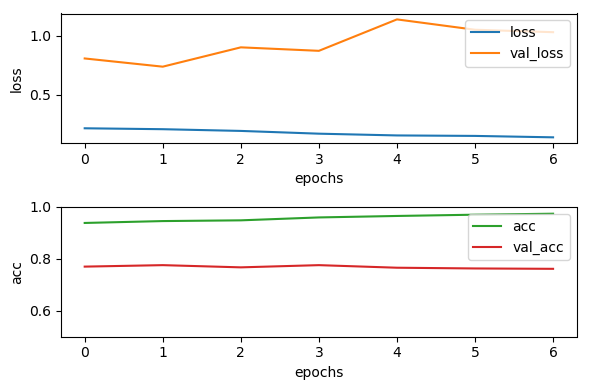

In [33]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()

In [ ]:
y_pred = model.predict(ts_set[0]).ravel()

In [ ]:
y_test = ts_set[1]
loss = metrics.log_loss(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred > 0.5)
prec = metrics.precision_score(y_test, y_pred > 0.5)
rcll = metrics.recall_score(y_test, y_pred > 0.5)
auc = metrics.roc_auc_score(y_test, y_pred)
print('Test scores:\n * Log-Loss\t{}\n * Accuracy:\t{}\n '
      '* Precision:\t{}\n * Recall:\t{}\n * AUC: \t{}'.format(loss, acc, prec, rcll, auc))

In [ ]:
from tangle.plotting import *

# Plot non-normalized confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred > 0.5)
plt.figure(dpi=100)
plot_confusion_matrix(cnf_matrix, classes=['METONLY', 'METX'],
                      title='Confusion matrix', cmap=plt.cm.Blues);

**TOP results so far [6341 training / 705 validation / 4698 test]**

Test scores:
 * Log-Loss	0.425300993082
 * Accuracy:	0.810131971052
 * Precision:	0.817983413357
 * Recall:	0.797786292039
 * AUC: 	0.894714579232

In [ ]:
model.save_weights('model.h5')